In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# get the pp data and hh_data
# classify based on the hh_type
data_folder = "data/pp_check"

In [3]:
hh_ipu = pd.read_csv(f"{data_folder}/syn_hh_ipu.csv") # use the mapping from seed directly

seed_hh = pd.read_csv(f"{data_folder}/hh_sample_ipu.csv")
seed_pp = pd.read_csv(f"{data_folder}/pp_sample_ipu.csv")

hh_csp = pd.read_csv(f"{data_folder}/syn_hh_ipf.csv")

pp_csp_seed = pd.read_csv(f"{data_folder}/csp_results_allz.csv")
pp_csp_bn = pd.read_csv(f"{data_folder}/csp_BN_from_IPF.csv")

pp_bn = pd.read_csv(f"{data_folder}/syn_pp_bn_hhsz_constraint.csv")

pp_ctgan = pd.read_csv(f"{data_folder}/syn_pp_ctgan_hhsz_constraint.csv")

hh_bn = pd.read_csv(f"{data_folder}/pure_BN_HH.csv")
pp_bn_csp_bn = pd.read_csv(f"{data_folder}/csp_BN_from_BN.csv")

pure_bn_hhtype = pd.read_csv(f"{data_folder}/hh_pureBN_hhtype_filter_constrained.csv")

C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_18572\127878667.py:18: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  pure_bn_hhtype = pd.read_csv(f"{data_folder}/hh_pureBN_hhtype_filter_constrained.csv")


In [4]:
assert set(seed_hh["serialno"]) == set(seed_pp["serialno"]), "The columns of the two hh dataframes are not the same"

In [5]:
seed_pp["relationship"].unique()

array(['Main', 'Spouse', 'Child', 'Parent', 'Sibling', 'Others',
       'Grandchild', 'Grandparent'], dtype=object)

In [6]:
def get_hh_type(ids_to_map: pd.Series, pp_data: pd.DataFrame, id_col: str="serialno", rela_col: str="relationship") -> pd.Series:
    pp_data_gb = pp_data.groupby(id_col)[rela_col].apply(list).reset_index(name=rela_col)
    def classify_hh_type(relationships):
        if "Main" not in relationships:
            raise ValueError("Main person not found in relationships")
        n_pp = len(relationships)
        if n_pp == 1:
            return "Single Person"
        if "Others" in relationships:
            return "Group Household"
        if set(relationships) == {"Main", "Spouse"}:
            return "Couple Only"
        if set(relationships) == {"Main", "Child"}:
            return "Single Parent"
        if set(relationships) == {"Main", "Child", "Spouse"}:
            return "Couple with Child"
        return "Complicated Family"
    pp_data_gb["hh_type"] = pp_data_gb[rela_col].apply(classify_hh_type)
    result = pd.DataFrame(ids_to_map)
    result["hh_type"] = result[id_col].map(pp_data_gb.set_index(id_col)["hh_type"])
    return result.set_index(id_col)["hh_type"]

In [7]:
seed_mapping = get_hh_type(seed_hh["serialno"], seed_pp)
csp_seed_mapping = get_hh_type(hh_csp["serialno"], pp_csp_seed)
csp_bn_mapping = get_hh_type(hh_csp["serialno"], pp_csp_bn)
bn_mapping = get_hh_type(hh_csp["serialno"], pp_bn)
ctgan_mapping = get_hh_type(hh_csp["serialno"], pp_ctgan)
bn_csp_mapping = get_hh_type(hh_bn["serialno"], pp_bn_csp_bn)

In [8]:
seed_hh["hh_type"] = seed_hh["serialno"].map(seed_mapping)
hh_ipu["hh_type"] = hh_ipu["serialno"].map(seed_mapping)

hh_csp_seed = hh_csp.copy()
hh_csp_seed["hh_type"] = hh_csp_seed["serialno"].map(csp_seed_mapping)

hh_csp_bn = hh_csp.copy()
hh_csp_bn["hh_type"] = hh_csp_bn["serialno"].map(csp_bn_mapping)

hh_bn = hh_csp.copy()
hh_bn["hh_type"] = hh_bn["serialno"].map(bn_mapping)

hh_ctgan = hh_csp.copy()
hh_ctgan["hh_type"] = hh_ctgan["serialno"].map(ctgan_mapping)

hh_bn["hh_type"] = hh_bn["serialno"].map(bn_csp_mapping)

<Axes: title={'center': 'Distribution of Total Vehicles by HH Type (VISTA)'}>

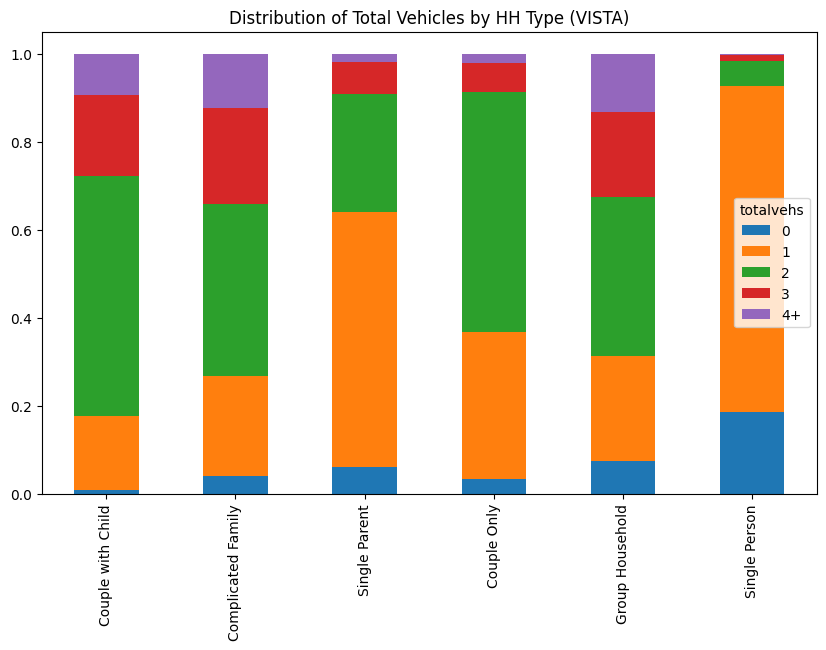

In [9]:
store = {}
for hh_type in seed_hh["hh_type"].unique():
    sub_df = seed_hh[seed_hh["hh_type"] == hh_type].copy()
    check_vehs = sub_df["totalvehs"].value_counts(normalize=True).reindex(["0", "1", "2", "3", "4+"], fill_value=0)
    store[hh_type] = check_vehs
pd.DataFrame(store).T.plot(kind="bar", stacked=True, figsize=(10, 6), title="Distribution of Total Vehicles by HH Type (VISTA)")

In [10]:
# Update to sort only if all HH Types are strings and avoid TypeError due to mixed types
def plot_grouped_stacked_vehs_by_hhtype(dfs_dict, vehicle_col="totalvehs", hhtype_col="hh_type", vehicle_order=None, title="Distribution of Total Vehicles by HH Type"):
    # Normalize and structure the data
    results = []
    for label, df in dfs_dict.items():
        for hh_type in df[hhtype_col].dropna().unique():
            sub_df = df[df[hhtype_col] == hh_type]
            norm_counts = sub_df[vehicle_col].value_counts(normalize=True).reindex(vehicle_order, fill_value=0)
            for vehs, value in norm_counts.items():
                results.append({
                    "Method": label,
                    "HH Type": hh_type,
                    "Vehicles": vehs,
                    "Proportion": value
                })

    plot_df = pd.DataFrame(results)

    # Ensure consistent category ordering only if safe
    hh_types = sorted([str(x) for x in plot_df["HH Type"].unique()])
    plot_df["HH Type"] = pd.Categorical(plot_df["HH Type"], ordered=True, categories=hh_types)
    plot_df["Method"] = pd.Categorical(plot_df["Method"], ordered=True, categories=sorted(dfs_dict.keys()))

    # Create multi-indexed table: rows = [HH Type, Method], columns = vehicle bins
    pivot_df = plot_df.pivot_table(index=["HH Type", "Method"], columns="Vehicles", values="Proportion", fill_value=0)

    # Plot with household type grouping and methods shown side-by-side
    ax = pivot_df.plot(kind="bar", stacked=True, figsize=(16, 7), colormap="tab20")
    ax.set_title(title)
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Household Type and Method")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [11]:
dfs_dict = {
    "IPU": hh_ipu.astype(str), 
    "CSP-Seed": hh_csp_seed.astype(str),
    "CSP-BN": pure_bn_hhtype.astype(str),
    "VISTA": seed_hh.astype(str),
    # "CSP-BN": hh_csp_bn,
    # "BN": hh_bn,
    # "CTGAN": hh_ctgan.astype(str),
    # "BN-CSP-BN": hh_bn
    }

In [12]:
# plot_grouped_stacked_vehs_by_hhtype(dfs_dict, vehicle_order=["0", "1", "2", "3", "4+"])

In [13]:
hhinc_order = [
    "Nil income",
    "1-149",
    "150-299",
    "300-399",
    "400-499",
    "500-649",
    "650-799",
    "800-999",
    "1000-1249",
    "1250-1499",
    "1500-1749",
    "1750-1999",
    "2000-2499",
    "2500-2999",
    "3000-3499",
    "3500-3999",
    "4000-4499",
    "4500-4999",
    "5000-5999",
    "6000-7999",
    "8000+"
]
vehs_order = ["0", "1", "2", "3", "4+"]

In [14]:
# store = {}
# for hh_type in seed_hh["hh_type"].unique():
#     print(hh_type)
#     sub_df = seed_hh[seed_hh["hh_type"] == hh_type].copy()
#     check_inc = sub_df["hhinc"].value_counts(normalize=True).reindex(hhinc_order, fill_value=0)
#     check_inc = check_inc.drop(["Nil income"])
#     store[hh_type] = check_inc
# pd.DataFrame(store).plot(kind="line", figsize=(15, 6), title="Distribution of Household Income by HH Type (VISTA)")

In [15]:
# store = {}
# for hh_type in seed_hh["hh_type"].unique():
#     print(hh_type)
#     sub_df = seed_hh[seed_hh["hh_type"] == hh_type].copy()
#     check_inc = sub_df["totalvehs"].value_counts(normalize=True).reindex(["0", "1", "2", "3", "4+"], fill_value=0)
#     store[hh_type] = check_inc
# pd.DataFrame(store).plot(kind="line", figsize=(15, 6), title="Distribution of total vehs by HH Type (VISTA)")

In [18]:
label_colors = {
    "IPU": "red", 
    "CSP-Seed": "blue",
    "CSP-BN": "green",
    "VISTA": "black",
    # "CSP-BN": hh_csp_bn,
    # "BN": hh_bn,
    # "CTGAN": hh_ctgan.astype(str),
    # "BN-CSP-BN": hh_bn
    }

In [27]:
from scipy.interpolate import make_interp_spline
import numpy as np

def check_dist_hh_type(dict_dfs, hh_type, att, orders, smooth=True):
    """
    Plot household att distribution for a given household type across multiple datasets.

    Parameters:
    - dict_dfs: dict of DataFrames, each with 'hh_type' and the specified attribute
    - hh_type: the specific household type to filter by
    - atts: the column name for check
    - orders: ordered list of categories
    - smooth: whether to apply smoothing to the lines (default: True)
    """
    store = {}
    for name, df in dict_dfs.items():
        sub_df = df[df["hh_type"] == hh_type].copy()
        check = sub_df[att].value_counts(normalize=True).reindex(orders, fill_value=0)
        if "Nil income" in check.index:
            check = check.drop("Nil income")
        store[name] = check

    df = pd.DataFrame(store)
    x_labels = df.index.tolist()
    x_numeric = np.arange(len(x_labels))

    plt.figure(figsize=(15, 6))

    for col in df.columns:
        y = df[col].values
        if smooth and len(x_numeric) >= 4:  # Ensure enough points for cubic spline
            x_smooth = np.linspace(x_numeric.min(), x_numeric.max(), 300)
            y_smooth = make_interp_spline(x_numeric, y, k=3)(x_smooth)
            plt.plot(x_smooth, y_smooth, label=col, color=label_colors[col], alpha=0.7)
        else:
            plt.plot(x_numeric, y, marker='o', label=col, color=label_colors[col], alpha=0.7)

    plt.xticks(ticks=x_numeric, labels=x_labels, rotation=45, ha='right')
    plt.title(f"Household {att} Distribution by HH Type ({hh_type})")
    plt.xlabel(att)
    plt.ylabel("Proportion")
    plt.legend()
    plt.tight_layout()
    plt.show()

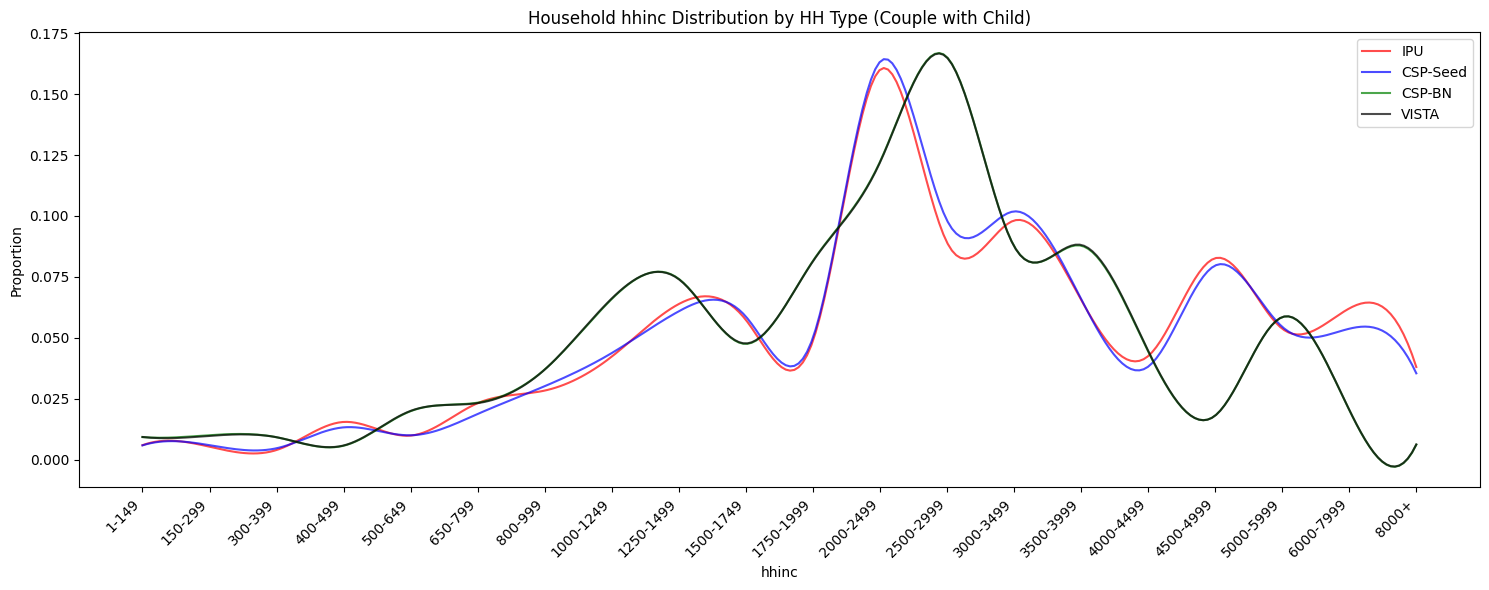

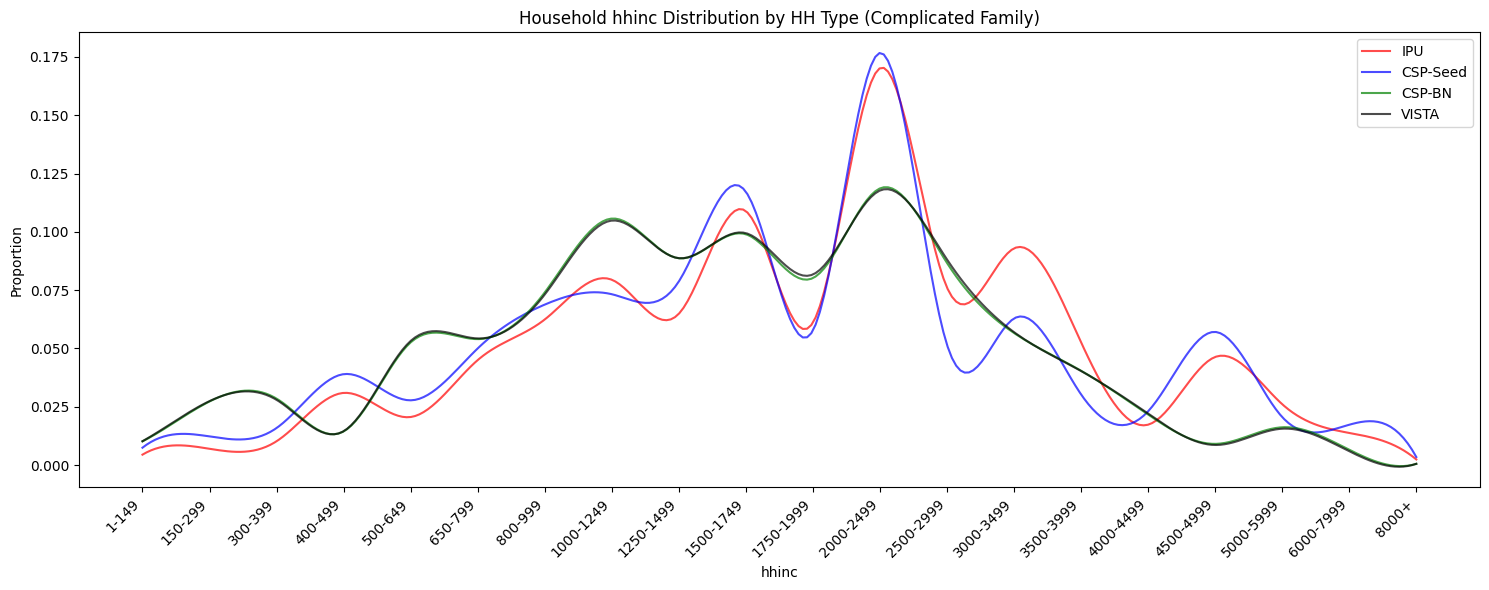

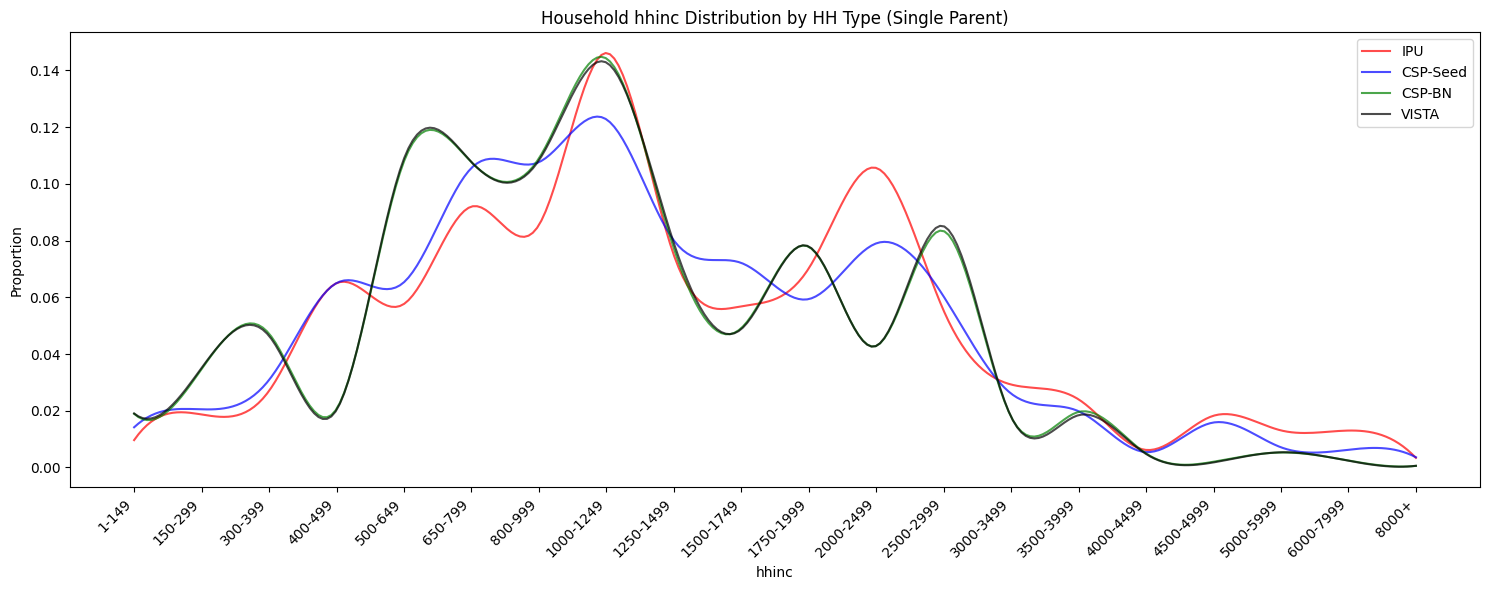

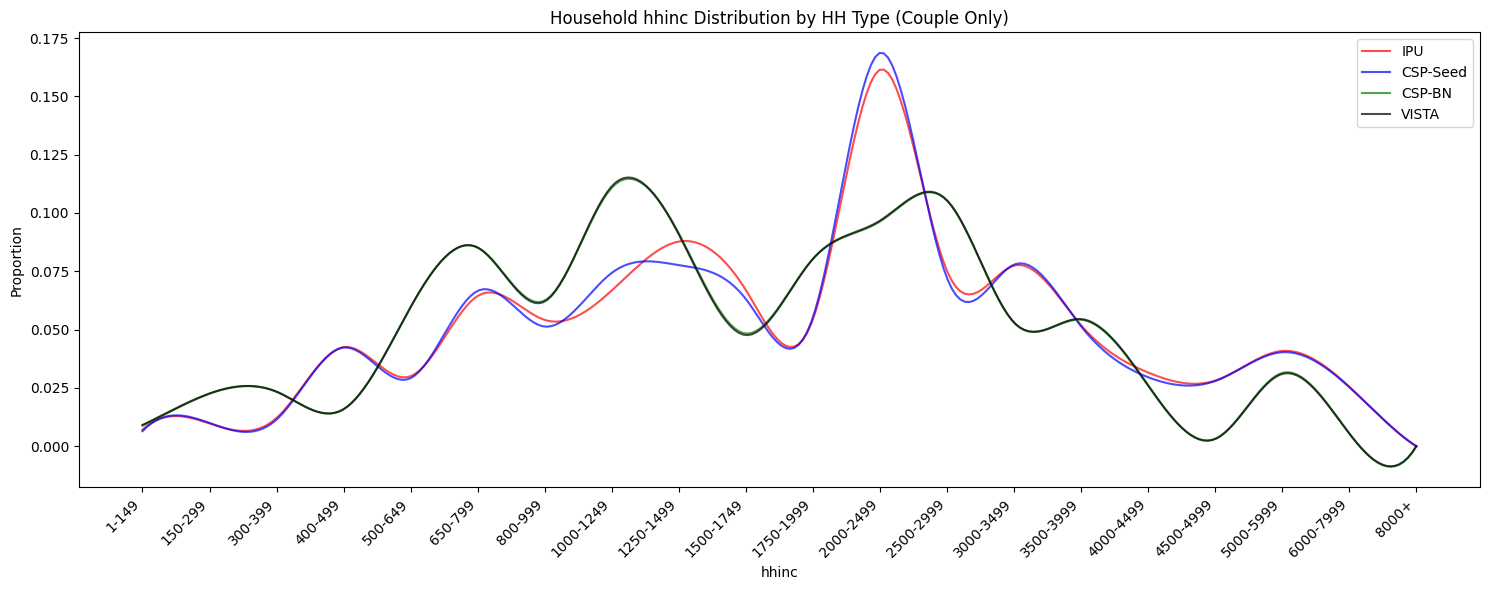

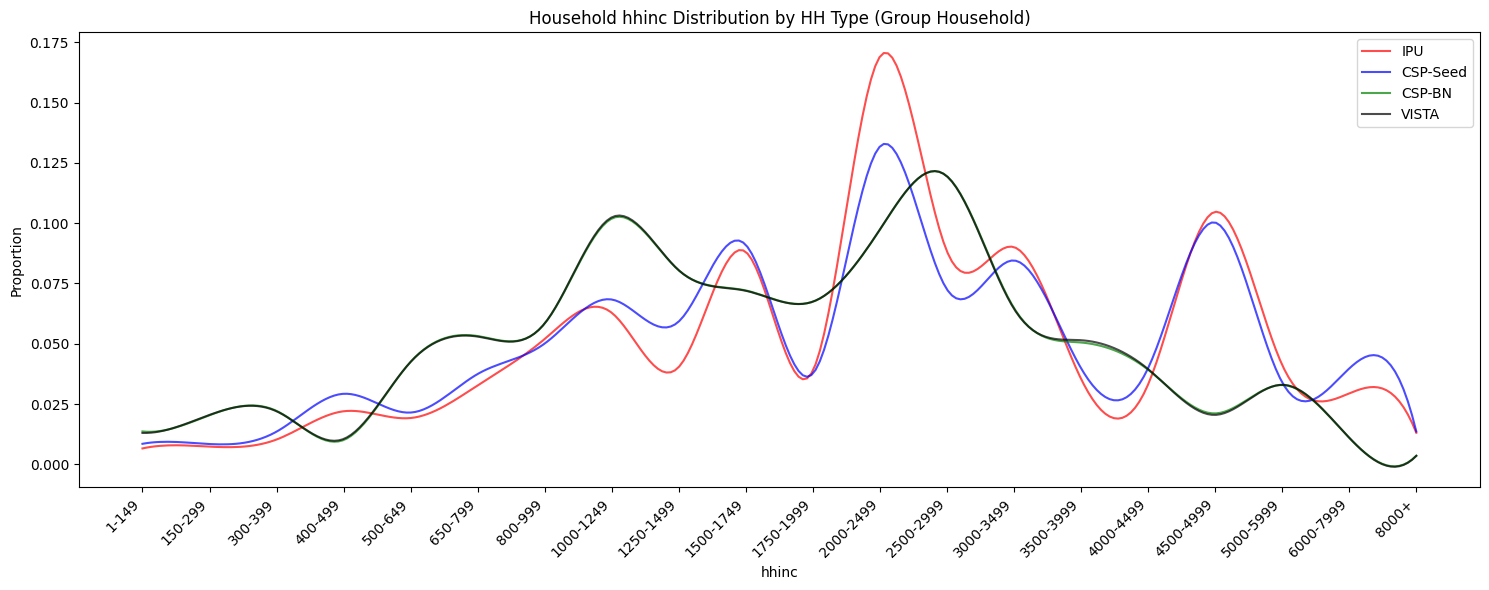

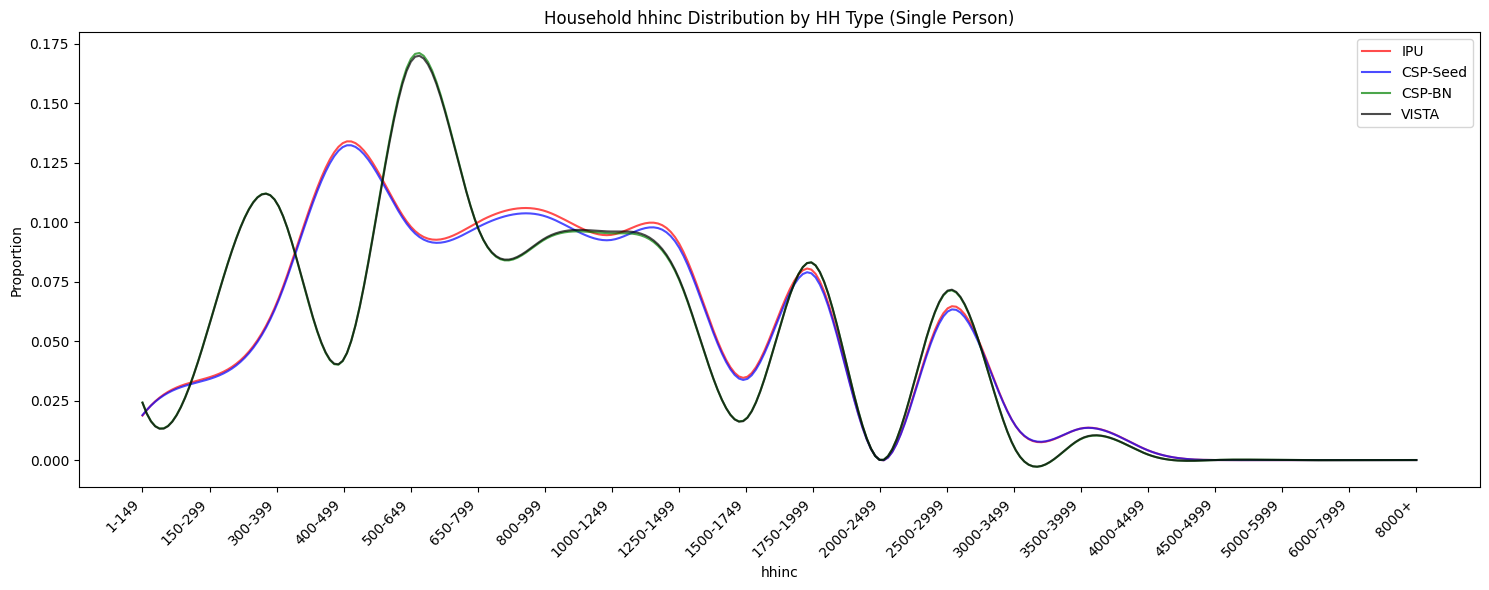

In [28]:
# hhinc
for hhtype in seed_hh["hh_type"].unique():
    check_dist_hh_type(dfs_dict, hhtype, "hhinc", hhinc_order)

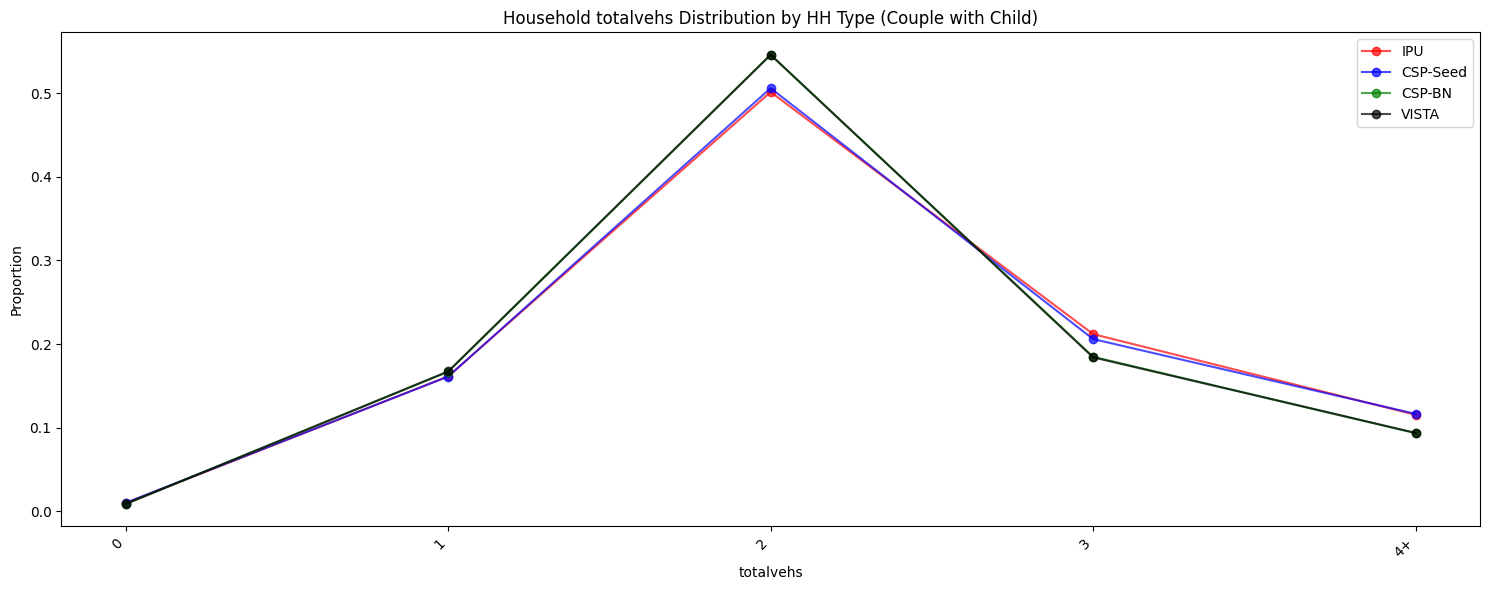

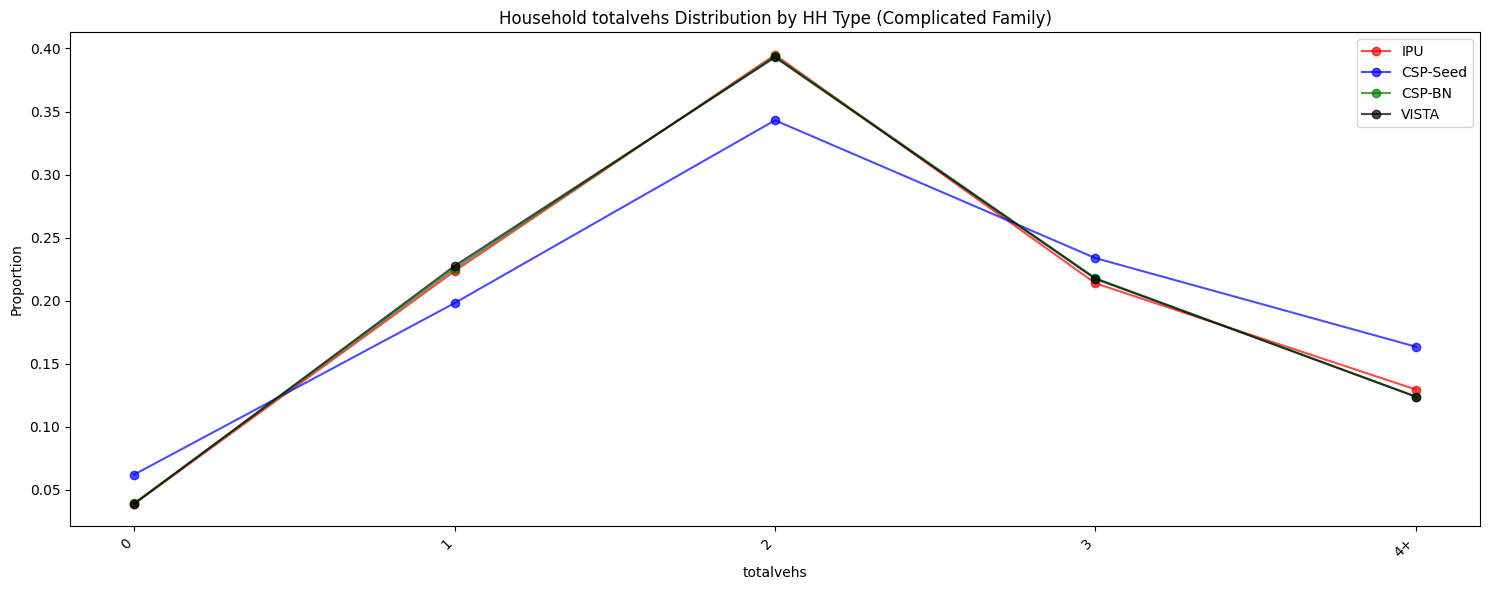

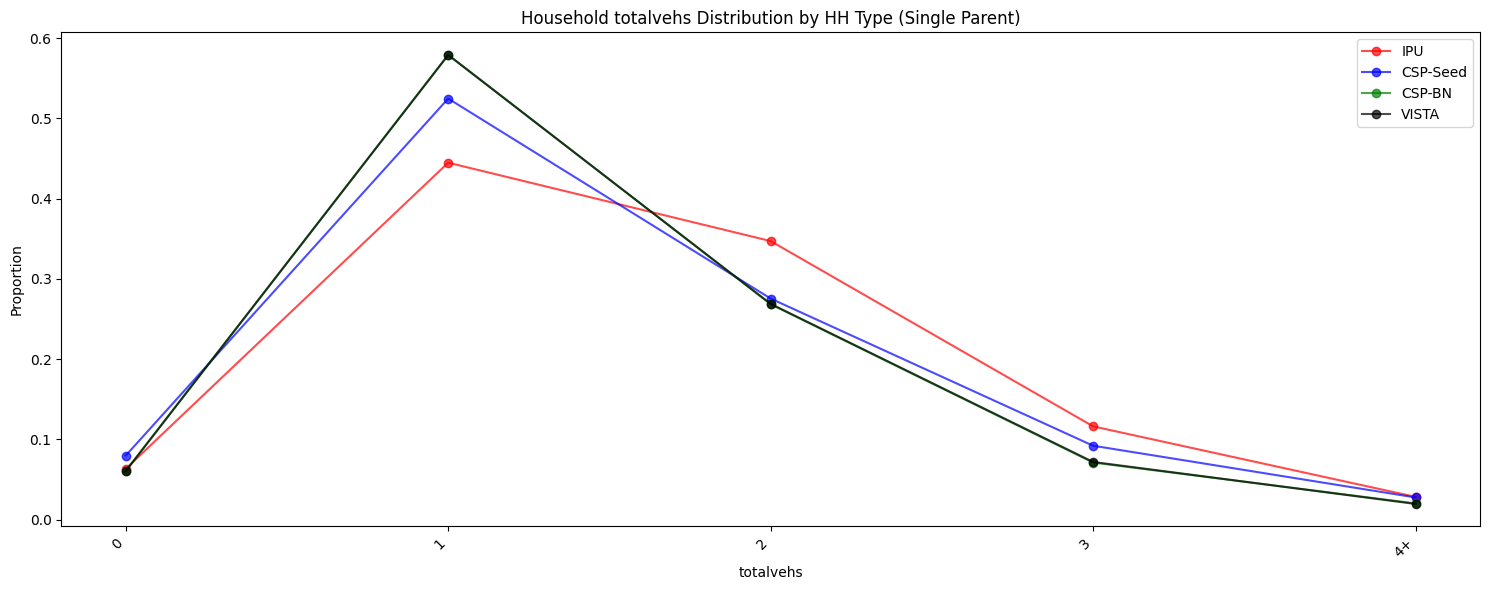

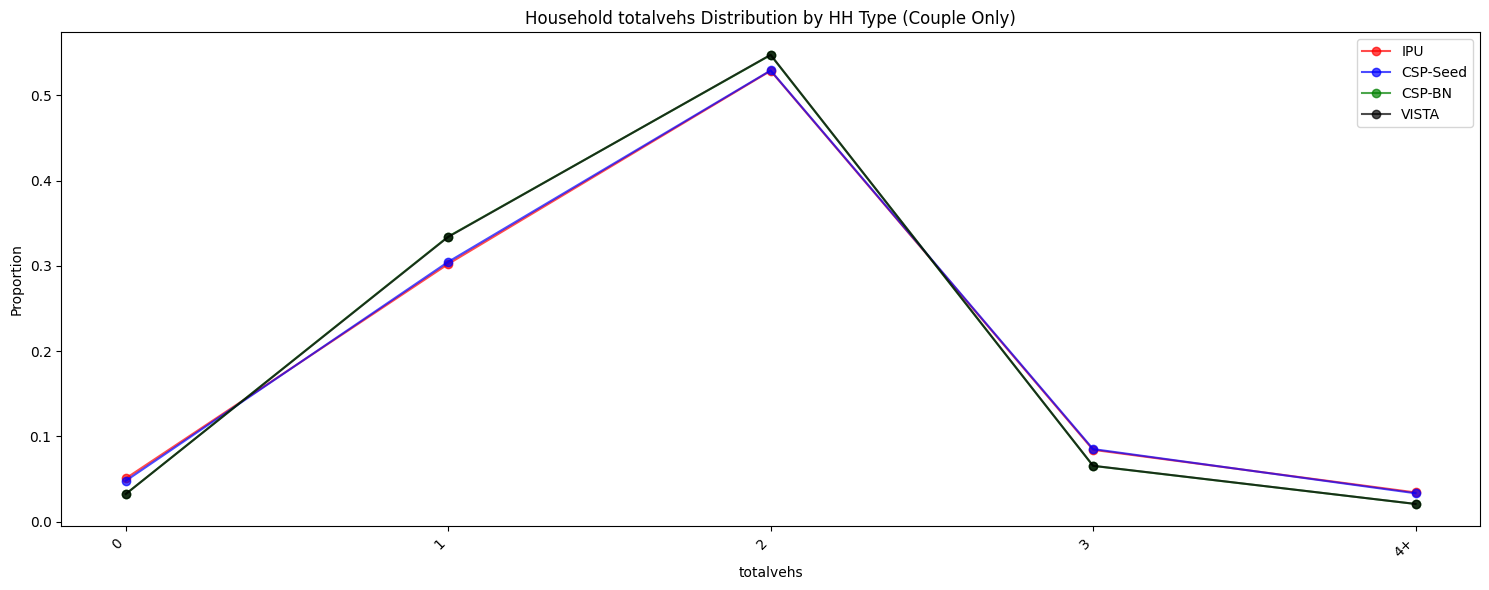

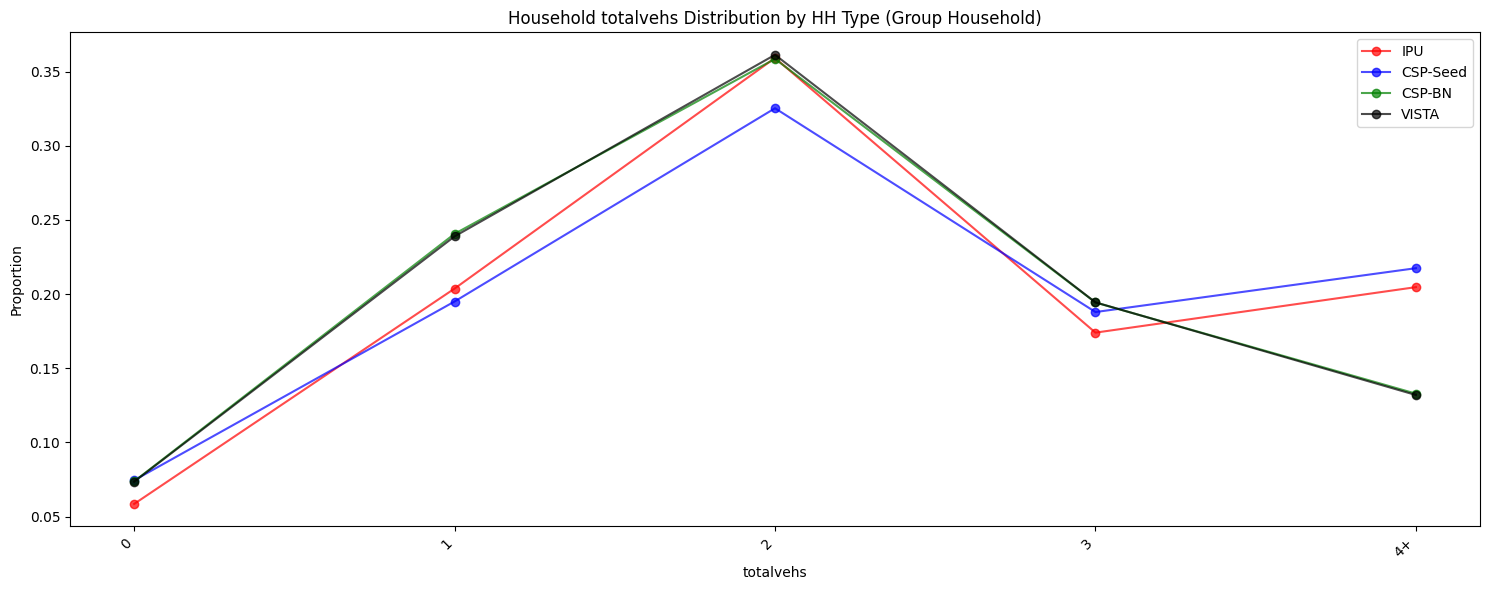

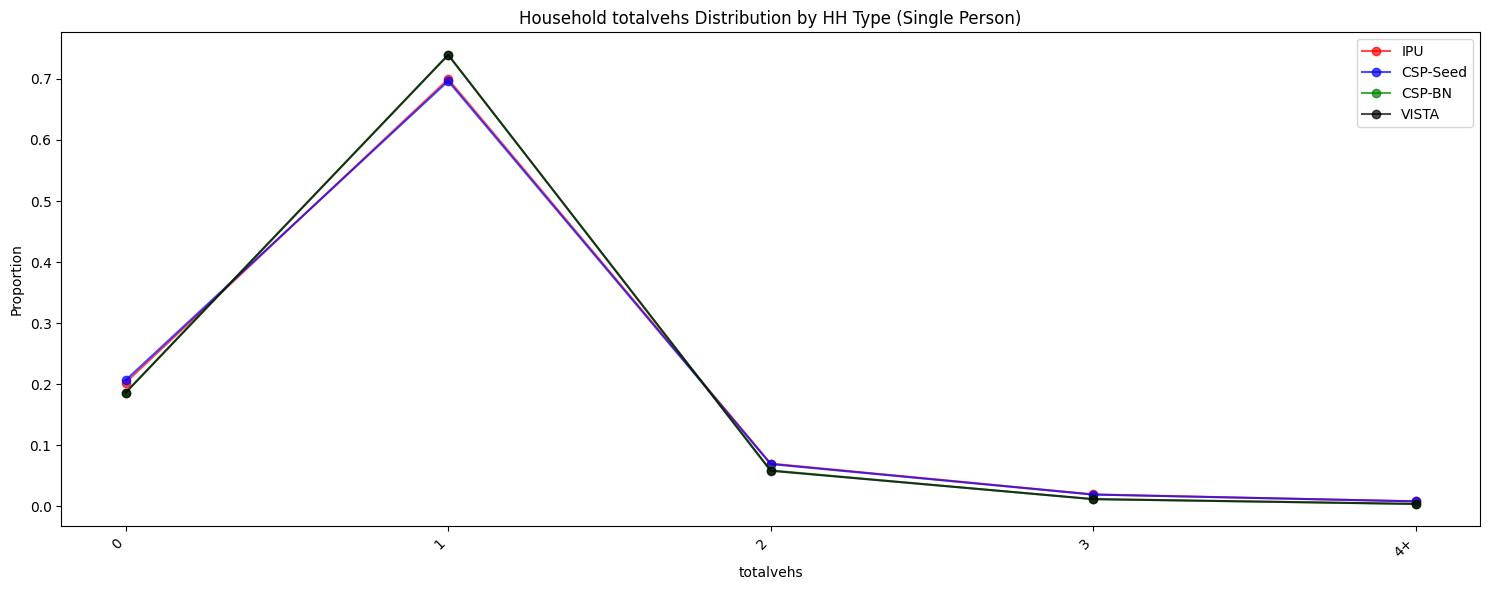

In [29]:
# check totalvehs
for hhtype in seed_hh["hh_type"].unique():
    check_dist_hh_type(dfs_dict, hhtype, "totalvehs", vehs_order, smooth=False)

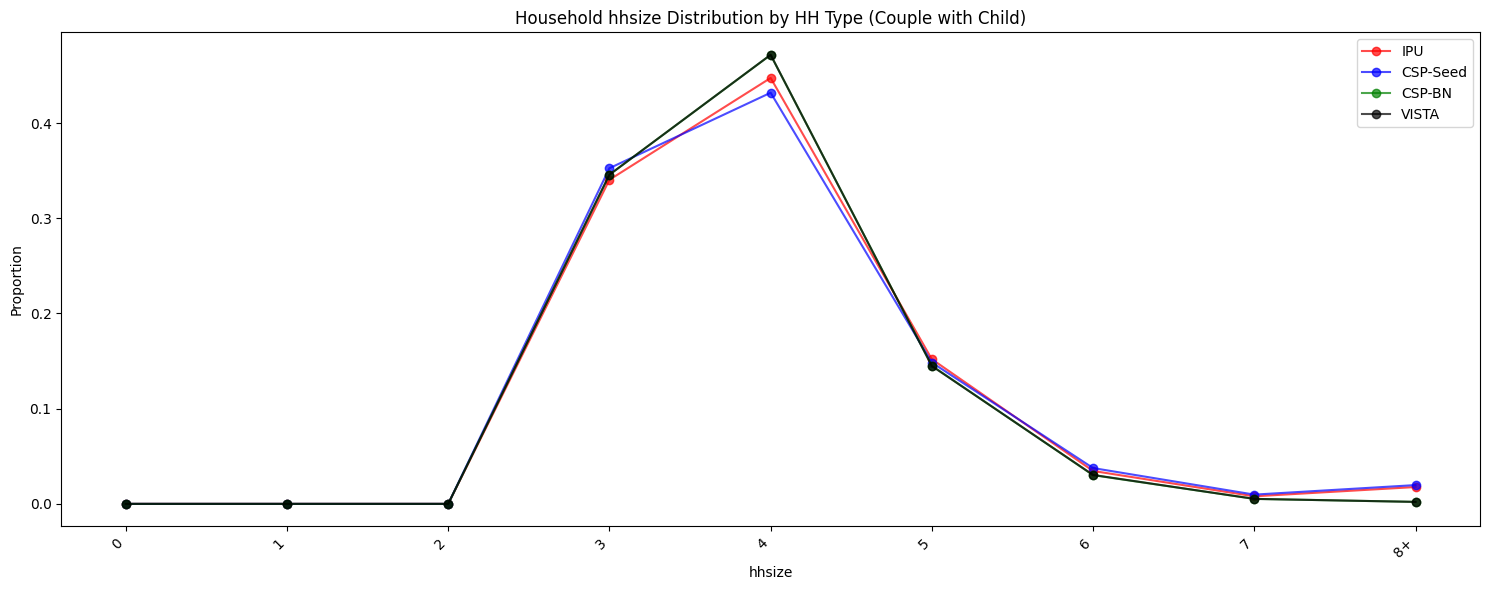

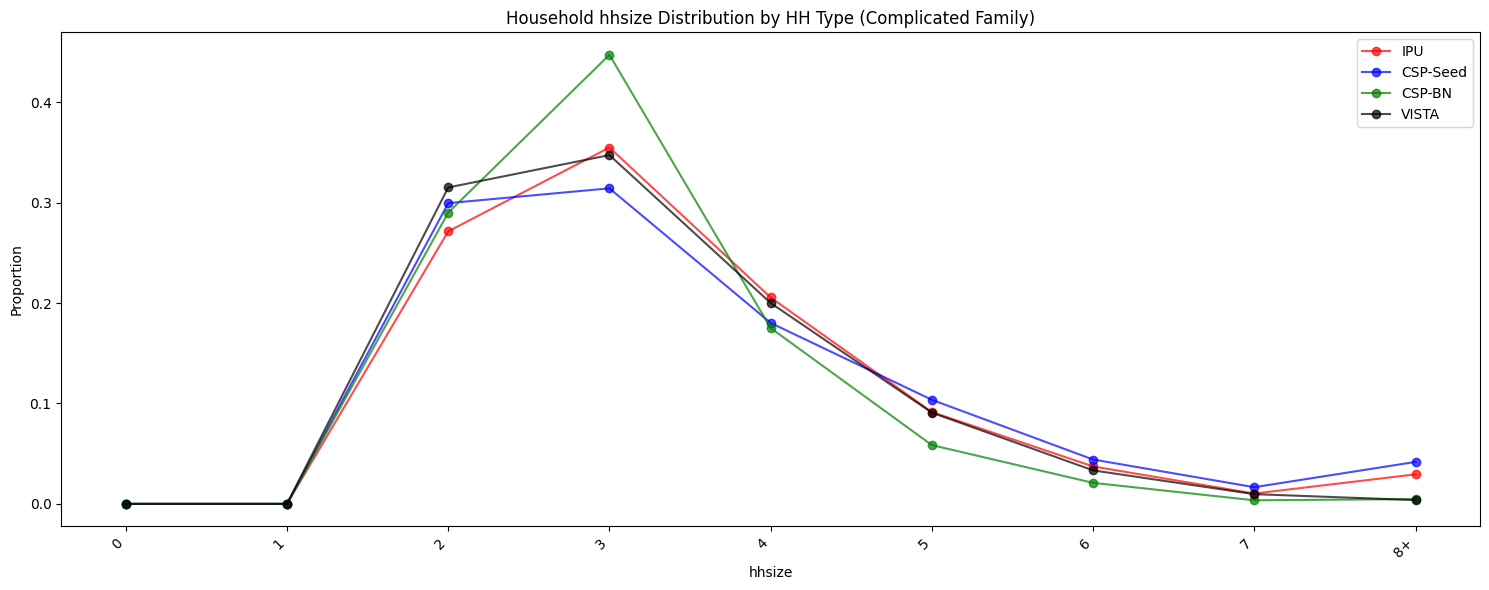

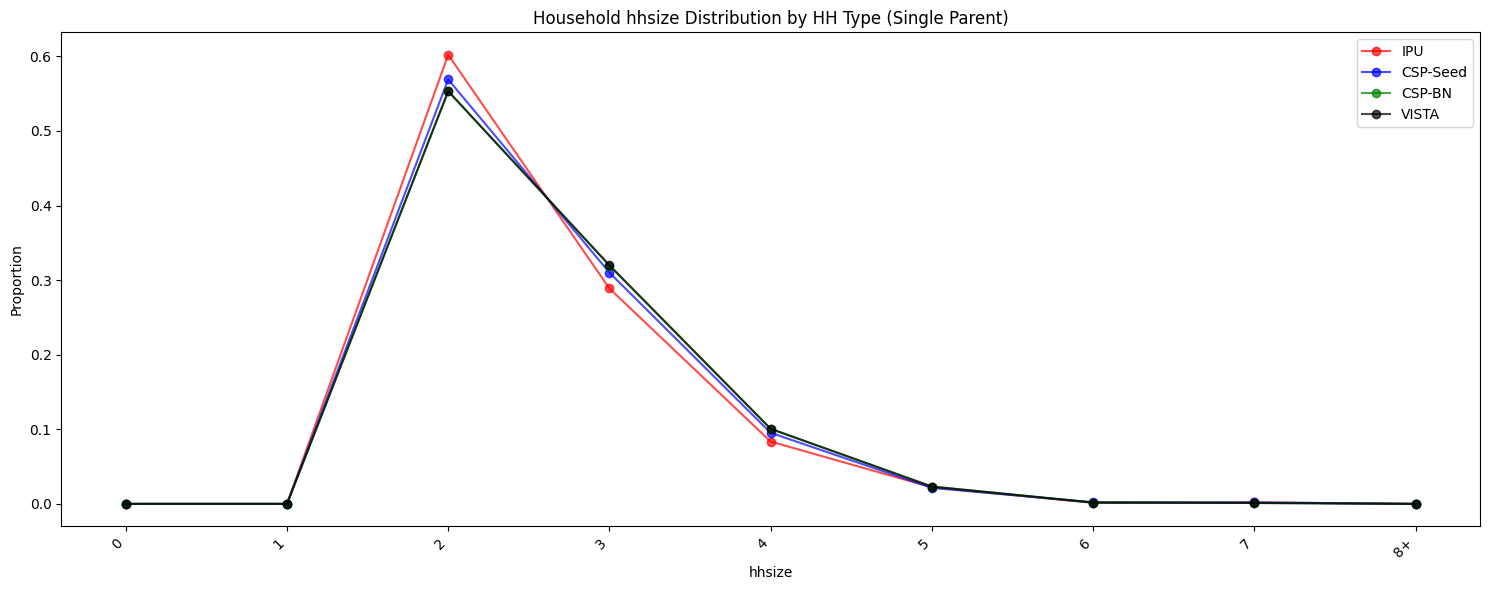

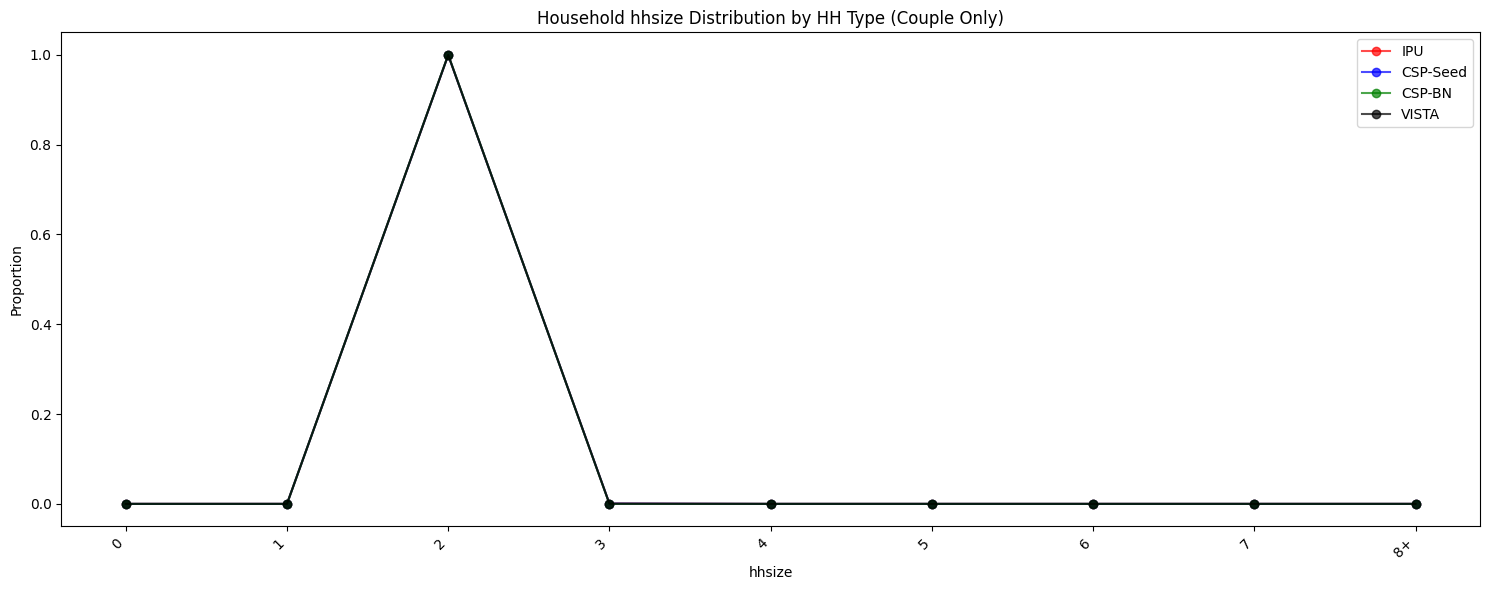

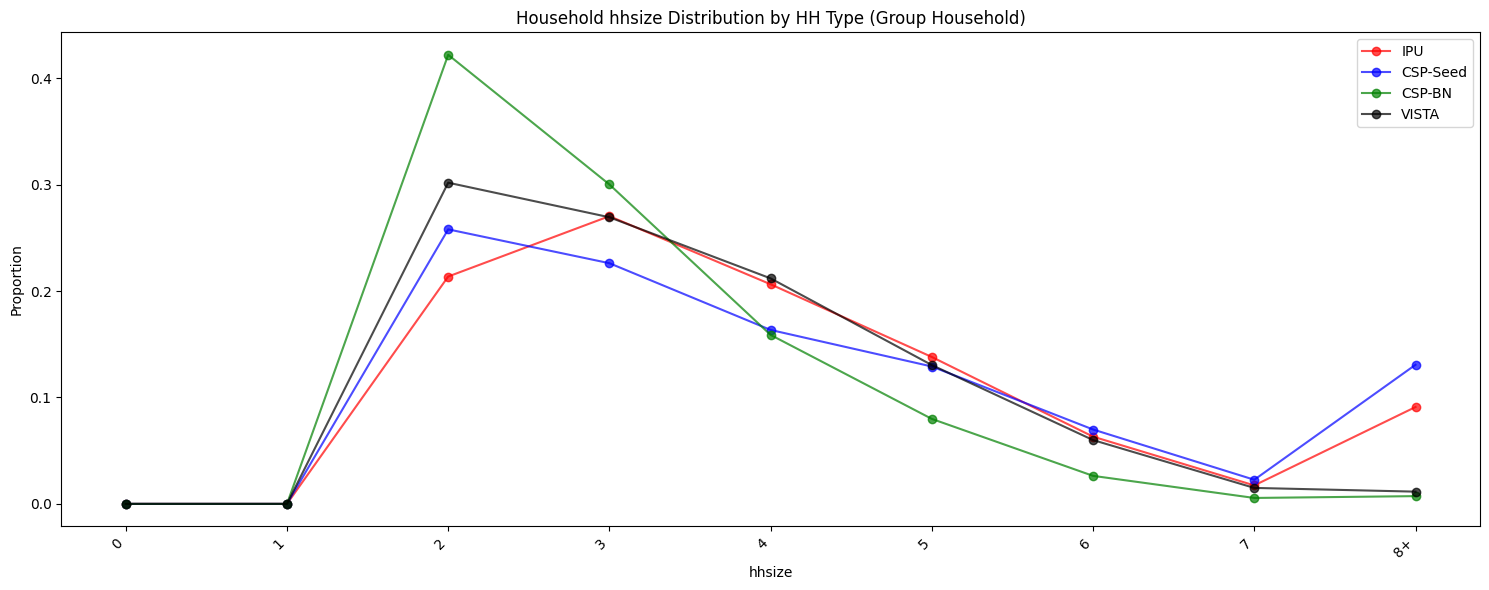

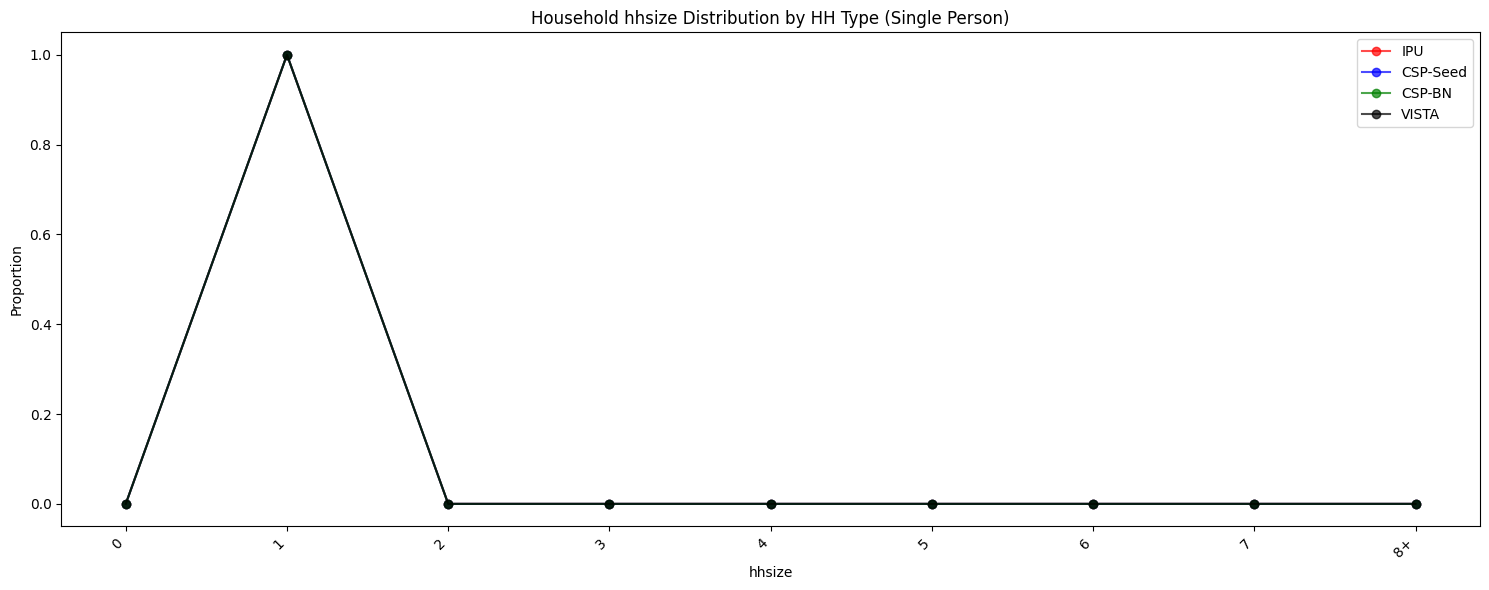

In [30]:
# check totalvehs
for hhtype in seed_hh["hh_type"].unique():
    check_dist_hh_type(dfs_dict, hhtype, "hhsize", ["0", "1", "2", "3", "4", "5", "6", "7", "8+"], False)

<Axes: ylabel='Proportion'>

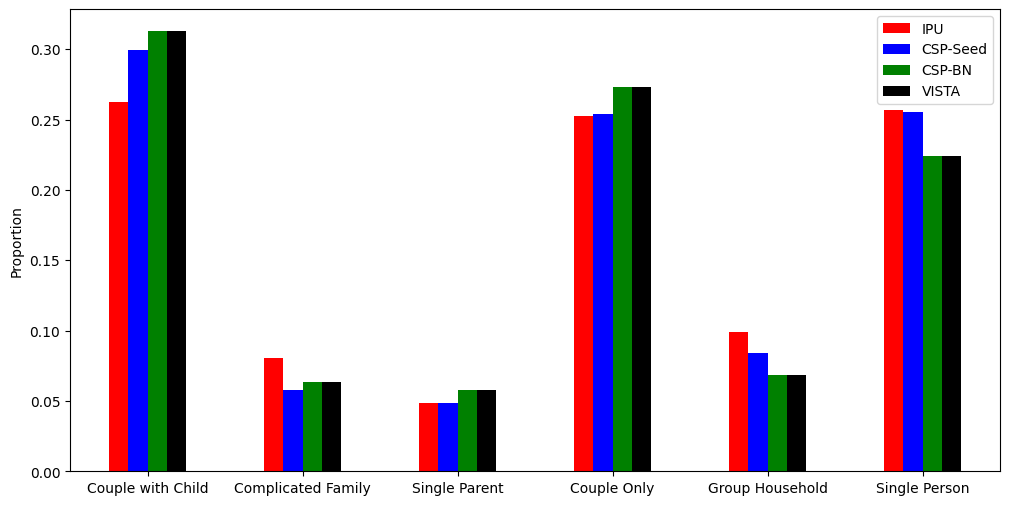

In [43]:
store = {}
for name, df in dfs_dict.items():
    store[name] = df["hh_type"].value_counts(normalize=True).reindex(seed_hh["hh_type"].unique(), fill_value=0)
pd.DataFrame(store).plot(kind="bar", figsize=(12, 6), color=[label_colors.get(col, 'grey') for col in store.keys()], rot=0, xlabel="", ylabel="Proportion")

In [34]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon

def compute_jsd(p, q):
    """Safe computation of Jensen-Shannon Distance"""
    return jensenshannon(p, q, base=2)

def get_jsd_table(dict_dfs, hh_types, atts):
    """
    Compute Jensen-Shannon Distance table for multiple household types and attributes.

    Parameters:
    - dict_dfs: dict of DataFrames (must include 'VISTA' as ground truth)
    - hh_types: list of household types to include
    - atts: list of attribute names to compare

    Returns:
    - MultiIndex DataFrame: (hh_type, attribute) as rows, dataset names as columns
    """
    assert "VISTA" in dict_dfs, "'VISTA' must be present as the ground truth"

    data = []

    for hh_type in hh_types:
        for att in atts:
            vista_df = dict_dfs["VISTA"]
            vista_sub = vista_df[vista_df["hh_type"] == hh_type]
            vista_counts = vista_sub[att].value_counts(normalize=True)

            jsd_scores = {}
            for name, df in dict_dfs.items():
                if name == "VISTA":
                    continue
                sub_df = df[df["hh_type"] == hh_type]
                dist_counts = sub_df[att].value_counts(normalize=True)

                all_cats = set(vista_counts.index).union(dist_counts.index)
                vista_aligned = vista_counts.reindex(all_cats, fill_value=0).values
                dist_aligned = dist_counts.reindex(all_cats, fill_value=0).values

                jsd = compute_jsd(vista_aligned, dist_aligned)
                jsd_scores[name] = jsd

            # Append to results list as a row
            data.append(((hh_type, att), jsd_scores))

    # Convert to DataFrame
    index = pd.MultiIndex.from_tuples([key for key, _ in data], names=["HH Type", "Attribute"])
    result_df = pd.DataFrame([vals for _, vals in data], index=index)

    return result_df


In [35]:
jsd_for_all = get_jsd_table(dfs_dict, seed_hh["hh_type"].unique(), [x for x in seed_hh.columns if x not in ["serialno", "hh_type", "sample_geog"]])

In [45]:
jsd_for_all

IPU  CSP-Seed    CSP-BN
HH Type            Attribute                              
Couple with Child  dwelltype  0.122875  0.109875  0.067708
                   owndwell   0.093075  0.084278  0.022547
                   hhinc      0.235420  0.219534  0.002041
                   totalvehs  0.047460  0.044210  0.000896
                   hhsize     0.075502  0.086018  0.000712
Complicated Family dwelltype  0.125328  0.108594  0.052586
                   owndwell   0.131762  0.138497  0.018009
                   hhinc      0.203170  0.202727  0.006885
                   totalvehs  0.008514  0.078204  0.002264
                   hhsize     0.097132  0.126623  0.100978
Single Parent      dwelltype  0.171456  0.146242  0.056881
                   owndwell   0.063852  0.096745  0.014865
                   hhinc      0.213241  0.177075  0.006652
                   totalvehs  0.119803  0.057825  0.002439
                   hhsize     0.044458  0.017187  0.003846
Couple Only        dwelltype  0.152713  0.140193  0.019382
                   owndwell   0.129251  0.127104  0.005246
                   hhinc      0.208502  0.208569  0.002770
                   totalvehs  0.064866  0.060515  0.000466
                   hhsize     0.002165  0.001827  0.015819
Group Household    dwelltype  0.144452  0.123724  0.068467
                   owndwell   0.077963  0.077151  0.019688
                   hhinc      0.250212  0.233252  0.004269
                   totalvehs  0.088030  0.099777  0.002701
                   hhsize     0.176003  0.219122  0.147802
Single Person      dwelltype  0.195305  0.186550  0.055871
                   owndwell   0.118145  0.123807  0.019629
                   hhinc      0.189189  0.190209  0.004502
                   totalvehs  0.047299  0.048639  0.001591
                   hhsize     0.000000  0.000000  0.000000

In [40]:
jsd_for_all.groupby(level="Attribute").mean()

,IPU,CSP-Seed,CSP-BN
Attribute,,,
dwelltype,0.152022,0.135863,0.053482
hhinc,0.216622,0.205228,0.004520
hhsize,0.065877,0.075130,0.044859
owndwell,0.102341,0.107930,0.016664
totalvehs,0.062662,0.064862,0.001726


<Axes: title={'center': 'Mean JSD per HH Type'}>

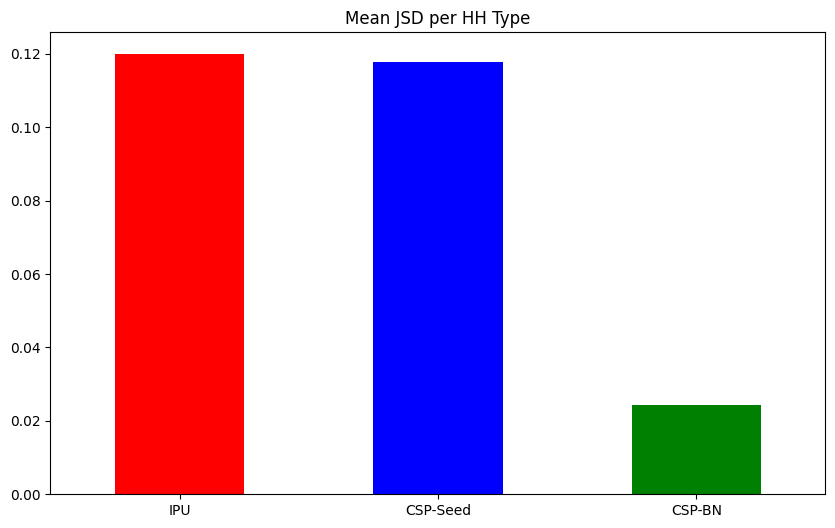

In [37]:
mean_jsd_per_hhtype = jsd_for_all.groupby(level="HH Type").mean()
mean_jsd_per_hhtype.mean().plot(kind="bar", figsize=(10, 6), title="Mean JSD per HH Type",color=[label_colors.get(col, 'grey') for col in store.keys()], rot=0)

<Axes: xlabel='HH Type', ylabel='Mean JSD'>

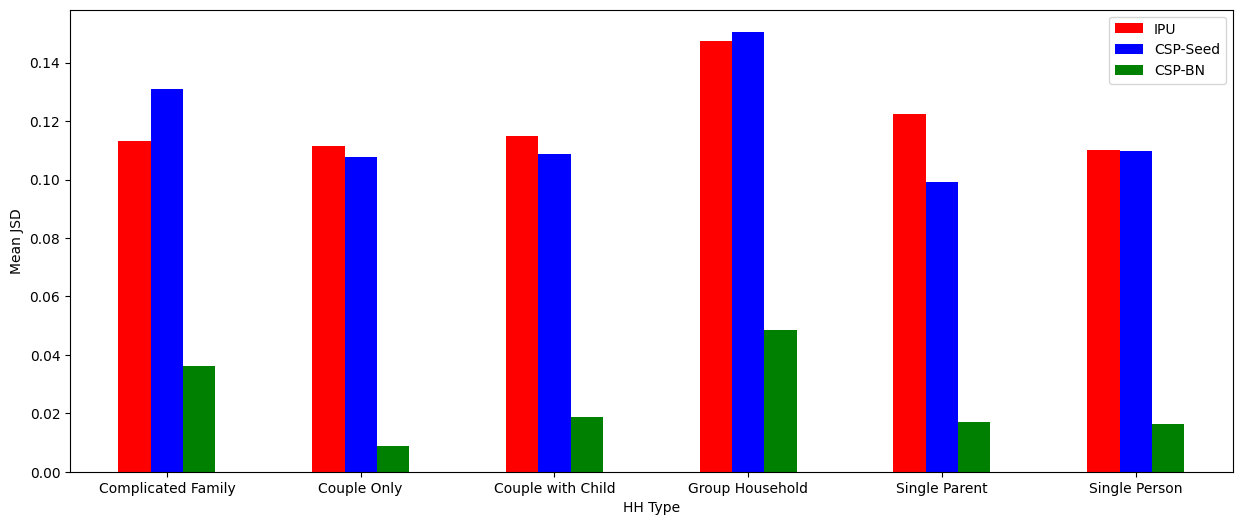

In [44]:
mean_jsd_per_hhtype.plot(kind="bar", figsize=(15, 6), ylabel="Mean JSD", rot=0, color=[label_colors.get(col, 'grey') for col in store.keys()])